In [1]:
# importing
%pylab inline
import pandas as pd
import seaborn as sns

import ipy_table

from IPython.display import display, Math, Latex, HTML, clear_output
from scipy import optimize

# set plot text soze
matplotlib.rcParams.update({'font.size': 14})

Populating the interactive namespace from numpy and matplotlib


# 1.Preparation 

## 1.1 Parameters for model 

In [2]:
N_eig = 15

In [3]:
eigenvalues = np.load('lab2_data/new_eigenvalues.npy')
print("Real: %s" % eigenvalues.real)
print("Imag: %s" % eigenvalues.imag)

Real: [-4.0634477  -2.38125981 -2.08185447 -4.16007062 -0.44738645 -1.70874879
 -2.22237478 -0.77799087 -0.38459865 -3.29976385 -2.82983978 -0.40125993
 -3.08194229 -0.49678683 -4.31856531]
Imag: [ 5.44925367  4.57277675  3.33890477  0.59493493  4.32536593  3.17255571
  4.22488651  5.01428523  0.4938021   1.93839564  5.99899502  5.78011929
  1.17344378  0.35221141  4.17774086]


In [4]:
#fc&fs=1
fc = np.ones(N_eig)
fs = np.ones(N_eig)

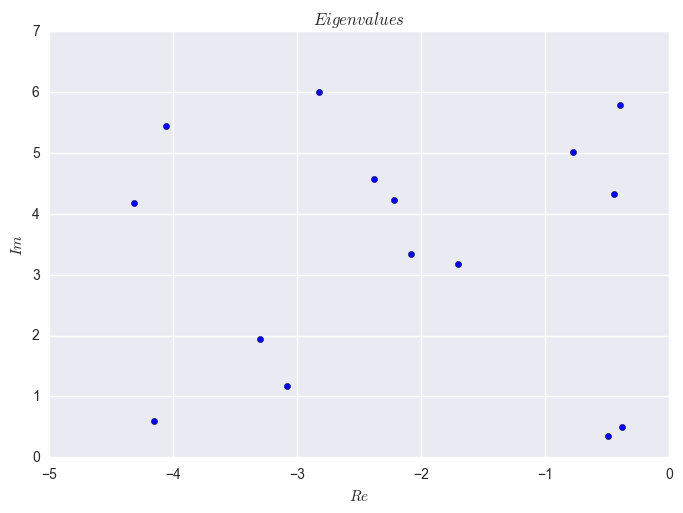

In [5]:
#plot eigenvalues
fig1, axes1 = plt.subplots()

axes1.scatter(eigenvalues.real, eigenvalues.imag)
axes1.set_xlabel('$Re$')
axes1.set_ylabel('$Im$')
_ = axes1.set_title('$Eigenvalues$')

## 1.2 Generate Y

$$y_k=\sum_{j=0}^{k-1} h_{k-j}u_j,$$
$$h_k=\sum_{p=1}^P \left(\rho_p^k (f_q^c\cos\omega_p(k-1)+f_q^s\sin\omega_p(k-1)\right),$$
<center>$\rho_p=\sqrt{\alpha_p^2+\beta_p^2}$,
$\omega_p=arccos\frac{\alpha_p}{\sqrt{\alpha_p^2+\beta_p^2}}$,
$\alpha_p=e^{\lambda_p\Delta}\cos\gamma_p\Delta$,
$\beta_p=e^{\lambda_p\Delta}\sin\gamma_p\Delta$</center>

We set $f_q^c=1$, $f_q^c=1$.

In [6]:
def y_cont(t, eigen, f_c, f_s):
    """continious impulse response"""
    res = 0
    for i in range(N_eig):
        res += (f_c[i]*np.cos(eigen[i].imag*t)+f_s[i]*np.sin(eigen[i].imag*t))*np.exp(eigen[i].real*t)
    return res

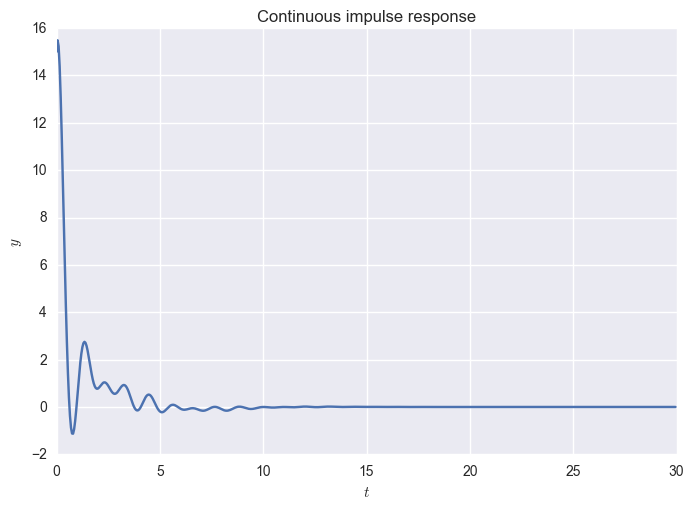

In [7]:
t = np.arange(0, 30, 0.05)
y_c = y_cont(t, eigenvalues, fc, fs)

fig2, axes2 = plt.subplots()

axes2.plot(t, y_c)
axes2.set_xlabel('$t$')
axes2.set_ylabel('$y$')
_ = axes2.set_title('Continuous impulse response')

## 1.3 Generate error

In [8]:
def norm_error(eps, n):
    error = []
    for i in range(n):
        a = np.random.normal(scale=eps/3)
        while abs(a)>eps:
            a = np.random.normal(scale=eps/3)
        error.append(a)
    return np.array(error)

In [9]:
def uniform_error(eps, n):
    return np.random.uniform(-eps, eps, size=n)

In [10]:
def two_peaks_error(eps, n):
    error = []
    for i in range(int(n/2)):
        a = np.random.normal(loc=-0.2, scale=eps/3)
        while abs(a)>eps:
            a = np.random.normal(loc=-0.2, scale=eps/3)
        error.append(a)
        a = np.random.normal(loc=0.2, scale=eps/3)
        while abs(a)>eps:
            a = np.random.normal(loc=0.2, scale=eps/3)
        error.append(a)
    if len(error)<n:
        a = np.random.normal(loc=0.2, scale=eps/3)
        while abs(a)>eps:
            a = np.random.normal(loc=0.2, scale=eps/3)
        error.append(a)
    return np.array(error)

## 1.4 Generate response

<center>$\alpha_p=e^{\lambda_p\Delta}\cos\gamma_p\Delta$</center> 
<center>$\beta_p=e^{\lambda_p\Delta}\sin\gamma_p\Delta$</center>

$$\rho_p=\sqrt{\alpha_p^2+\beta_p^2},\; \omega_p=arccos\frac{\alpha_p}{\sqrt{\alpha_p^2+\beta_p^2}}$$

$$y_k=\sum_{j=0}^{k-1} h_{k-j}u_j,$$
$$h_k=\sum_{p=1}^P \left(\rho_p^k (f_q^c\cos\omega_p(k-1)+f_q^s\sin\omega_p(k-1)\right)$$

In [11]:
def calculate_a_b(delta):
    alpha = [np.exp(el.real*delta)*np.cos(el.imag*delta) for el in eigenvalues]
    beta = [np.exp(el.real*delta)*np.sin(el.imag*delta) for el in eigenvalues]
    return np.array(alpha), np.array(beta)

In [12]:
def calculate_response(delta, N, J, alpha, beta):
    length = 2 * N * J
    rho = np.sqrt(alpha**2+beta**2)
    omega = np.arccos(alpha/rho)
    h = [np.sum(rho**i*(fc*np.cos(omega*i)+fs*np.sin(omega*i))) for i in range(length)]
    u = np.hstack((np.ones(N), np.zeros(N))*J)
    y = np.convolve(h, u)[:length]
    return np.array(y), np.array(u), np.array(h)

In [13]:
def plot_error(error, eps):
    fig4, axes4 = plt.subplots()

    weights = np.ones_like(error)/(float(len(error)))

    n, bins, patches = axes4.hist(error, 50, range = (-1.0, 1.0), facecolor='blue', weights=weights)

    axes4.set_xlabel('error')
    axes4.set_ylabel('likelihood')
    axes4.set_xlim(-1.3*eps, 1.3*eps)
    axes4.set_ylim(0, max(n)+0.05)
    axes4.set_title('Error plot')

In [14]:
def calculate_parameters(eps, split_depth, T, J, gen_error, if_plot=False):
    """
    Returns alpha, beta, y_real, u, h_real, error, y_noisy.
    """ 
    split_depth = 5
    delta = T / 2**(split_depth + 1)
    N = round(T/delta)
    length = 2 * N * J
    alpha, beta = calculate_a_b(delta)
    y_real, u, h_real = calculate_response(delta, N, J, alpha, beta)

    np.random.seed(0)
    error = gen_error(eps, length)

    y_noisy = y_real + error
    
    if if_plot:
        t = np.linspace(0, T * 2 * J, length)

        fig3, axes3 = plt.subplots(figsize=(16, 7))

        axes3.plot(t, y_real, label = '$y_{noisy}$')
        axes3.plot(t, h_real, label = '$h_{real}$')
        axes3.set_xlabel('$k$')
        axes3.set_ylabel('$y_k$')
        axes3.legend()
        axes3.set_title('Discrete response')
        
        fig4, axes4 = plt.subplots(figsize=(16, 7))

        axes4.plot(t, [y_real[i]/error[i] for i in range(length)])
        axes4.set_xlabel('k')
        axes4.set_ylabel('$y_k/error_k$')
        axes4.set_title('$y/\\varepsilon$')        
        plot_error(error, eps)
        
    return dict(alpha=alpha, beta=beta, y=y_real, signal=u,
                h=h_real, noise=error, y_noisy=y_noisy, delta=delta)

In [15]:
Eps = 0.5 #0.01 - 0.05    *max(y)
T = 20
split_depth = 5
no_stages = 5

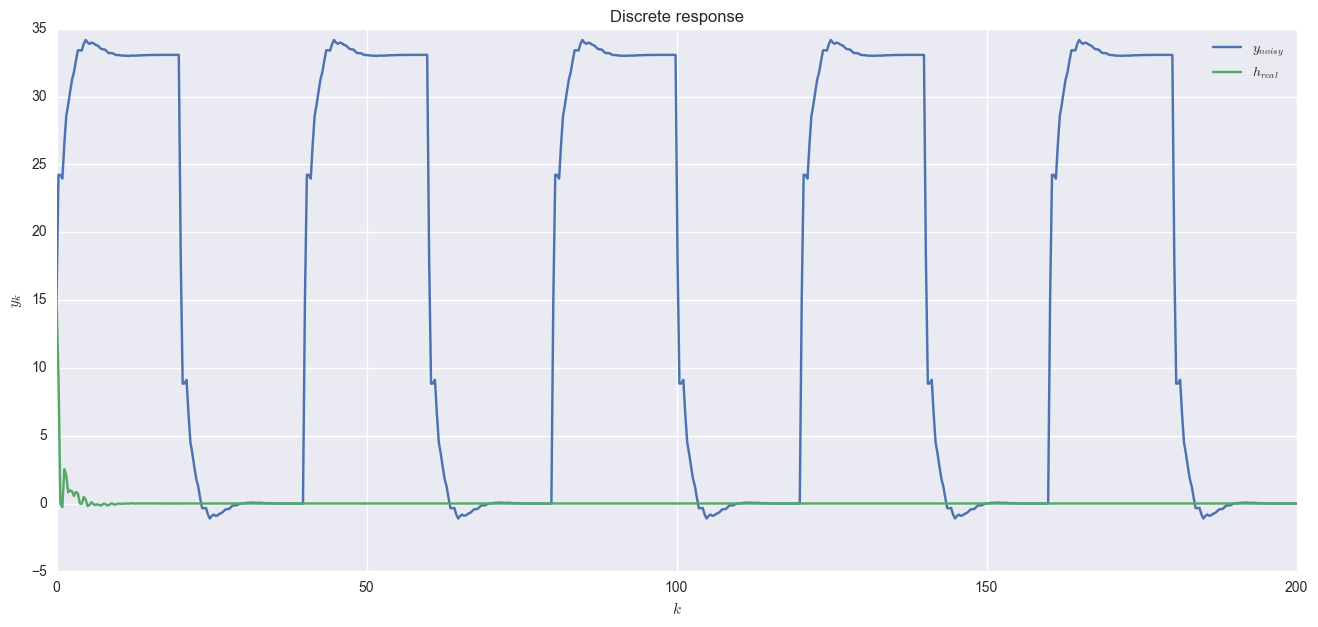

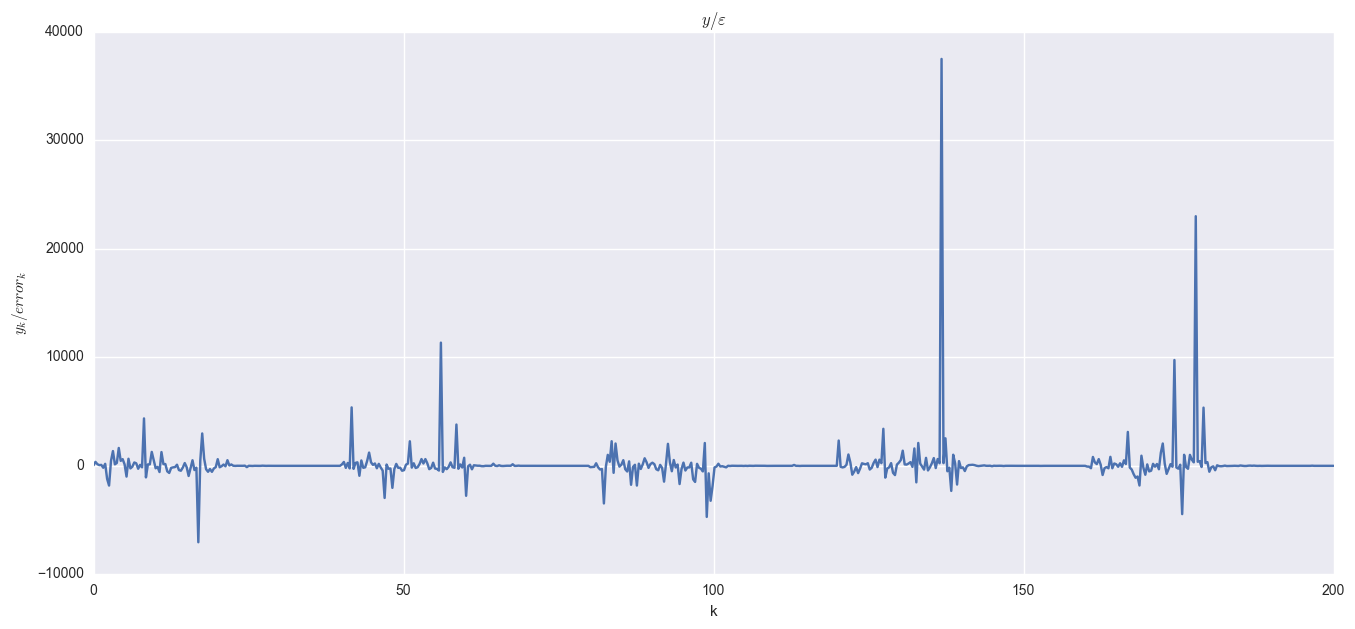

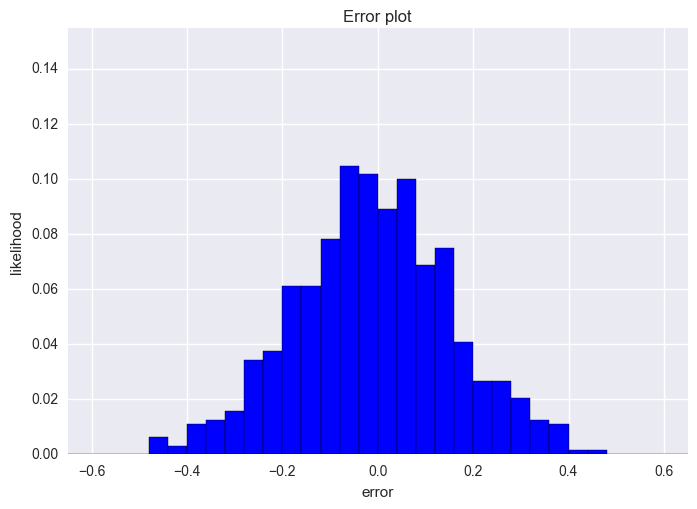

In [16]:
params = calculate_parameters(Eps, split_depth, T, no_stages, norm_error, True)

## 1.6 Calculating confidence intervals

In [17]:
# exporting data to disk in txt format
# only need to export y_noisy
np.savetxt('y_noisy.txt', params['y_noisy'])